In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import itertools
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neural_network import MLPClassifier
import joblib


In [2]:
def load_and_preprocess_data(file_path, save_scalers=False):
    """
    Load data from a CSV file, handling semicolon delimiters and comma decimals.
    Scales numeric columns and fills missing values.

    :param file_path: Path to the CSV file
    :param save_scalers: If True, saves the scalers to disk using joblib
    :return: DataFrame with preprocessed and scaled data
    """
    # Loading the data
    data = pd.read_csv(file_path, delimiter=';', decimal=',')

    # Filling missing values
    for col in data.select_dtypes(include=['float64', 'int64']):
        data[col].fillna(data[col].mean(), inplace=True)

    for col in data.select_dtypes(include=['object']):
        data[col].fillna(data[col].mode()[0], inplace=True)

    # Convert categorical data to numeric
    data["Sex M/F"] = data["Sex M/F"].apply(lambda x: x == "M")
    data["BCG - therapy [YES/NO]"] = data["BCG - therapy [YES/NO]"].apply(lambda x: x == 1)
    data["OUTCOME [0 - TUMOUR FREE. 1 - RECURRENCE]"] = data["OUTCOME [0 - TUMOUR FREE. 1 - RECURRENCE]"].apply(lambda x: x == 1.0)
    
    # Drop columns that are not features
    data.drop(["No"], axis='columns', inplace=True)
    data.drop(["Age [years]"], axis='columns', inplace=True)

    # Scale numeric columns
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    # Save the scalers if required
    if save_scalers:
        joblib.dump(scaler, 'scaler.pkl')

    return data

file_path = "./InputData2.csv"
data = load_and_preprocess_data(file_path)

# Assuming the last column is the target variable
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

data.head()

,Sex M/F,BCG - therapy [YES/NO],PAI-1 serum,SUPAR serum,IL-8 serum,IL-8 urine,VEGF urine,APOE urine,OUTCOME [0 - TUMOUR FREE. 1 - RECURRENCE]
0,True,True,1.460666,7.167776e-01,-0.490491,-0.189572,-0.302858,-0.119619,False
1,False,True,0.498326,-8.747384e-01,-0.479434,-0.189572,-0.421837,-0.130045,False
2,True,False,0.000000,3.473096e-16,-0.507976,-0.467484,0.457060,-0.111800,True
3,True,False,-0.848375,1.407347e+00,-0.524935,-0.510032,-0.415042,-0.137863,True
4,True,True,0.151365,1.407347e+00,-0.291091,-0.572133,-0.440829,-0.122226,True


In [3]:
# Function to calculate the AUC with confidence interval
def compute_auc_ci(y_true, y_scores, n_bootstraps=1000, alpha=0.95):
    bootstrapped_scores = []
    
    rng = np.random.RandomState(seed=42)  # for reproducibility
    for _ in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true.iloc[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue
        score = roc_auc_score(y_true.iloc[indices], y_scores[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    # Computing the lower and upper bound of the confidence interval
    lower = sorted_scores[int((1.0-alpha)/2.0 * len(sorted_scores))]
    upper = sorted_scores[int((alpha+((1.0-alpha)/2.0)) * len(sorted_scores))]
    
    return lower, upper

### Various Architectures Hypermarameter Tuning

Logistic Regression
Random Forest


/mnt/c/Users/filip/MedLink/experimentation/Sampling/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30600 fits failed out of a total of 32400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
576 fits failed with the following error:
Traceback (most recent call last):
  File "/mnt/c/Users/filip/MedLink/experimentation/Sampling/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/mnt/c/Users/filip/MedLink/experimentation/Sampling/venv/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/mnt/c/Users/filip/MedLink/experimentation

SVM
Naive Bayes
KNN
MLP


/mnt/c/Users/filip/MedLink/experimentation/Sampling/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/c/Users/filip/MedLink/experimentation/Sampling/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/c/Users/filip/MedLink/experimentation/Sampling/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/c/Users/filip/MedLink/experimentation/Sampling/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Opti

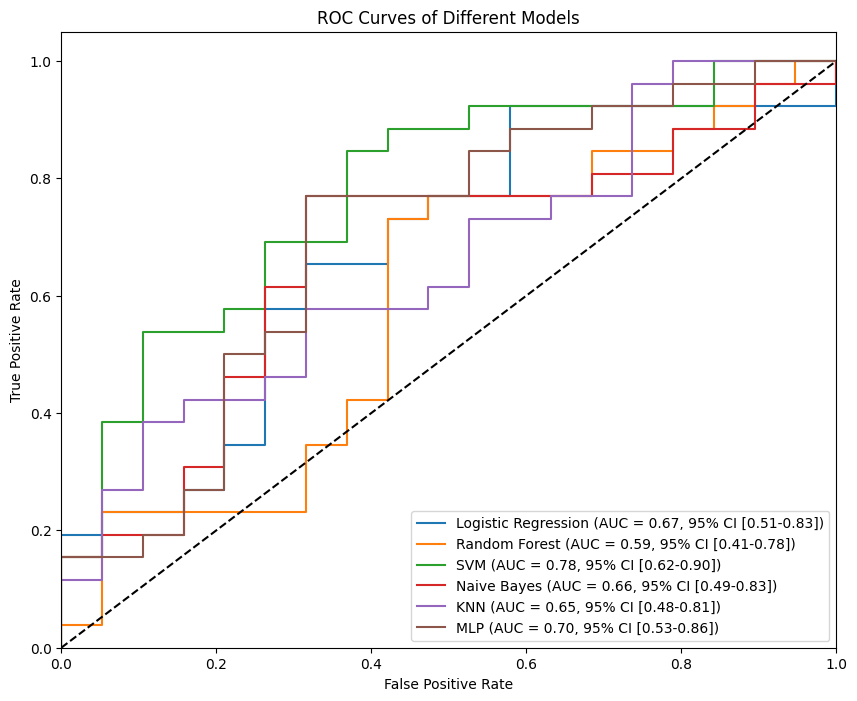

Logistic Regression: AUC = 0.67 with 95% CI [0.51-0.83]
Random Forest: AUC = 0.59 with 95% CI [0.41-0.78]
SVM: AUC = 0.78 with 95% CI [0.62-0.90]
Naive Bayes: AUC = 0.66 with 95% CI [0.49-0.83]
KNN: AUC = 0.65 with 95% CI [0.48-0.81]
MLP: AUC = 0.70 with 95% CI [0.53-0.86]


In [5]:
# Models and their respective parameter grids for GridSearch
models = {
    "Logistic Regression": (LogisticRegression(), 
            {
                "C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "liblinear"]
            }),
    "Random Forest": (RandomForestClassifier(),
            {
                'n_estimators': [int(x) for x in np.linspace(start=50, stop=1000, num=10)],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth': [None] + list(np.linspace(10, 110, num=11)),
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            }),
    "SVM": (SVC(probability=True),
            {
                'C': [0.1, 0.5, 1, 1.2, 1.5],
                'kernel': ['rbf', 'poly'], #',
                'gamma': ['scale', 'auto']}),
    "Naive Bayes": (GaussianNB(), 
            {
                'var_smoothing': np.logspace(1,-11, num=300)
            }),
    "KNN": (KNeighborsClassifier(),
            {
                'n_neighbors': [3, 5, 7, 10],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            }),
    "MLP": (MLPClassifier(max_iter=200),
            {
                'hidden_layer_sizes': [(5,), (10,), (20,), (5, 5), (10, 10)],
                'activation': ['tanh', 'relu'],
                'solver': ['sgd', 'adam'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant','adaptive'],
            })
}

# Dictionary to store ROC AUC results
roc_results = {}
trained_models = {}


# Running GridSearchCV for each model
for name, (model, param_grid) in models.items():
    print(name)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    trained_models[name] = best_model
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_lower, auc_upper = compute_auc_ci(y_test, y_pred_proba)
    roc_results[name] = (fpr, tpr, roc_auc, auc_lower, auc_upper)


# Plotting ROC Curves and printing AUC with Confidence Interval
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc, auc_lower, auc_upper) in roc_results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f}, 95% CI [{auc_lower:.2f}-{auc_upper:.2f}])")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Different Models')
plt.legend(loc="lower right")
plt.show()

# Optionally, print out the AUC and confidence intervals
for name, (_, _, roc_auc, auc_lower, auc_upper) in roc_results.items():
    print(f"{name}: AUC = {roc_auc:.2f} with 95% CI [{auc_lower:.2f}-{auc_upper:.2f}]")

### Permutation Importance

Text(0.5, 0, 'Permutation Importance')

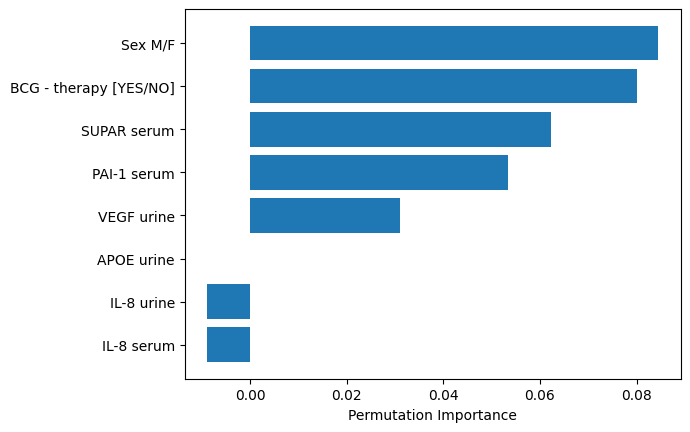

In [6]:
from sklearn.inspection import permutation_importance

columns_indexes = {i: c for i, c in enumerate(data.columns)}
perm_importance = permutation_importance(trained_models["SVM"], X_test, y_test)

feature_names = list(columns_indexes.values())[:-1]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")    


## Feature Elimination

You can systematically remove each feature (or sets of features) from your model and observe the impact on performance metrics (like ROC-AUC score, accuracy, F1 score, etc.). A significant drop in performance upon removing a feature indicates its importance.

For the conclusive study we measure the impact of single and pairs of features.

### Single feature elimination

Feature Sex M/F removed, AUC: 0.6923076923076923
Feature BCG - therapy [YES/NO] removed, AUC: 0.3785425101214575
Feature PAI-1 serum removed, AUC: 0.7348178137651822
Feature SUPAR serum removed, AUC: 0.7226720647773279
Feature IL-8 serum removed, AUC: 0.7489878542510121
Feature IL-8 urine removed, AUC: 0.7732793522267207
Feature VEGF urine removed, AUC: 0.7307692307692308
Feature APOE urine removed, AUC: 0.21862348178137658


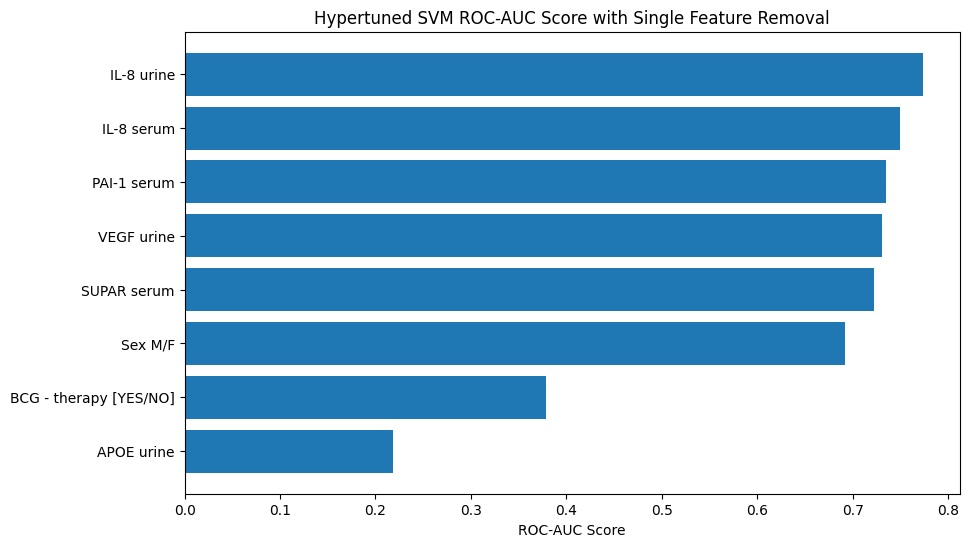

In [7]:
name = "SVM"
model, param_grid = models[name] 

res = {}
# Feature elimination
for i in range(X_train.shape[1]):
    # Drop the current feature from the dataset
    X_train_reduced = np.delete(X_train, i, axis=1)
    X_test_reduced = np.delete(X_test, i, axis=1)

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_reduced, y_train)
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test_reduced)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    res[i] = (fpr, tpr, roc_auc)

    print(f"Feature {columns_indexes[i]} removed, AUC: {roc_auc}")


# Extracting feature names and their corresponding ROC-AUC scores
features = [columns_indexes[i] for i in res]
roc_auc_scores = [details[2] for details in res.values()] 

# Sorting the features based on ROC-AUC scores
sorted_idx = sorted(range(len(roc_auc_scores)), key=lambda i: roc_auc_scores[i], reverse=True)
sorted_features = [features[i] for i in sorted_idx]
sorted_scores = [roc_auc_scores[i] for i in sorted_idx]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_scores ) #, color='skyblue')
plt.xlabel("ROC-AUC Score")
plt.title("Hypertuned SVM ROC-AUC Score with Single Feature Removal")
plt.gca().invert_yaxis()  # To display the highest score at the top
plt.show()

### Pair of features elimination

Features ('Sex M/F', 'BCG - therapy [YES/NO]') removed, AUC: 0.7388663967611336
Features ('Sex M/F', 'PAI-1 serum') removed, AUC: 0.694331983805668
Features ('Sex M/F', 'SUPAR serum') removed, AUC: 0.6194331983805668
Features ('Sex M/F', 'IL-8 serum') removed, AUC: 0.3441295546558705
Features ('Sex M/F', 'IL-8 urine') removed, AUC: 0.6518218623481782
Features ('Sex M/F', 'VEGF urine') removed, AUC: 0.3441295546558705
Features ('Sex M/F', 'APOE urine') removed, AUC: 0.687246963562753
Features ('BCG - therapy [YES/NO]', 'PAI-1 serum') removed, AUC: 0.6224696356275303
Features ('BCG - therapy [YES/NO]', 'SUPAR serum') removed, AUC: 0.6113360323886641
Features ('BCG - therapy [YES/NO]', 'IL-8 serum') removed, AUC: 0.3319838056680162
Features ('BCG - therapy [YES/NO]', 'IL-8 urine') removed, AUC: 0.659919028340081
Features ('BCG - therapy [YES/NO]', 'VEGF urine') removed, AUC: 0.5951417004048583
Features ('BCG - therapy [YES/NO]', 'APOE urine') removed, AUC: 0.6052631578947368
Features ('PA

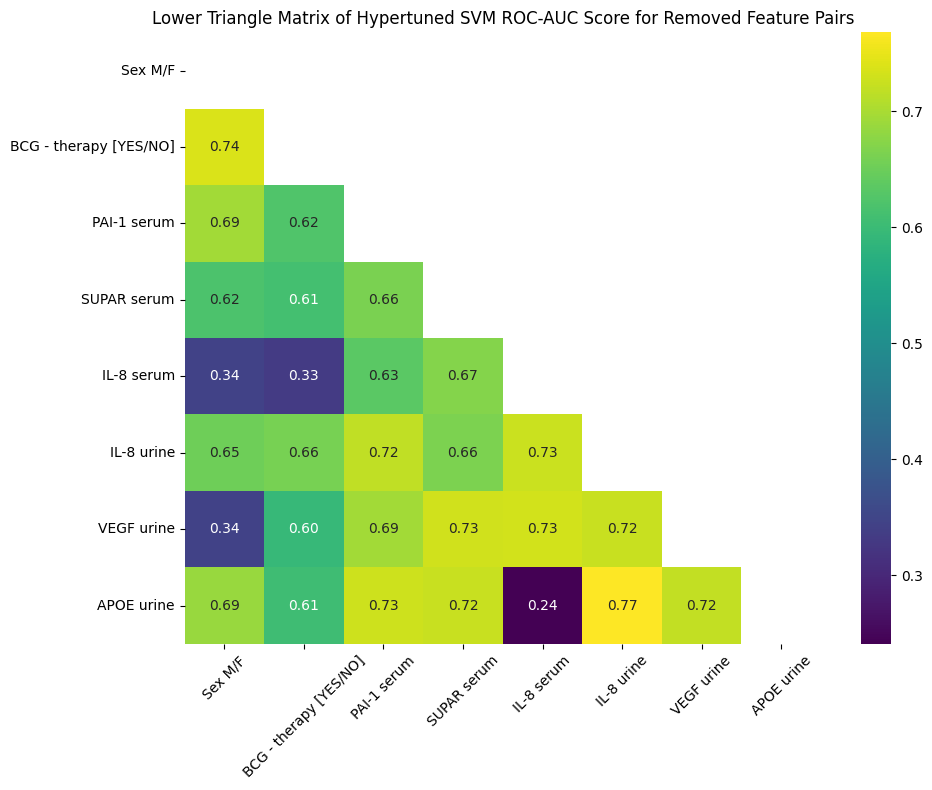

In [9]:
from itertools import combinations
import seaborn as sns

name = "SVM"
model, param_grid = models[name] 
resdouble = {}
# model = SVC(probability=False)

# Iterate over all pairs of features
for i, j in combinations(range(X_train.shape[1]), 2):
    # Remove the pair of features from the dataset
    X_train_reduced = np.delete(X_train, [i, j], axis=1)
    X_test_reduced = np.delete(X_test, [i, j], axis=1)

    # Perform Grid Search
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_reduced, y_train)
    best_model = grid_search.best_estimator_

    # Evaluate the model
    y_pred_proba = best_model.predict_proba(X_test_reduced)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Save the results
    resdouble[(i, j)] = {
        'fpr': fpr, 
        'tpr': tpr, 
        'roc_auc': roc_auc, 
    }

    # Print the result
    feature_pair = (columns_indexes[i], columns_indexes[j])
    print(f"Features {feature_pair} removed, AUC: {roc_auc}")


# Number of features
n_features = X_train.shape[1]

# Initialize the matrix with NaN values
roc_auc_matrix = np.full((n_features, n_features), np.nan)

# Fill the matrix with ROC-AUC scores from the results
for (i, j), metrics in resdouble.items():
    roc_auc_score = metrics['roc_auc']
    roc_auc_matrix[i, j] = roc_auc_score
    roc_auc_matrix[j, i] = roc_auc_score  # Symmetric matrix
    
feature_names_list = [n for _,n in columns_indexes.items()][:-1] 

# Ensure the matrix is square and the feature names list matches the number of features
assert roc_auc_matrix.shape[0] == roc_auc_matrix.shape[1] == len(feature_names_list)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(roc_auc_matrix, dtype=bool))

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(roc_auc_matrix, mask=mask, annot=True, fmt=".2f", cmap='viridis',
            xticklabels=feature_names_list, yticklabels=feature_names_list)
plt.title("Lower Triangle Matrix of Hypertuned SVM ROC-AUC Score for Removed Feature Pairs")
plt.xticks(rotation=45)  # Rotate x-tick labels for better readability
plt.yticks(rotation=0)  # Ensure y-tick labels are horizontal for readability
plt.tight_layout()  # Adjust layout so everything fits without overlapping
plt.show()

## Plot Decision boundry of the SVM

0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 2
1 3
1 4
1 5
1 6
1 7
2 3
2 4
2 5
2 6
2 7
3 4
3 5
3 6
3 7
4 5
4 6
4 7
5 6
5 7
6 7


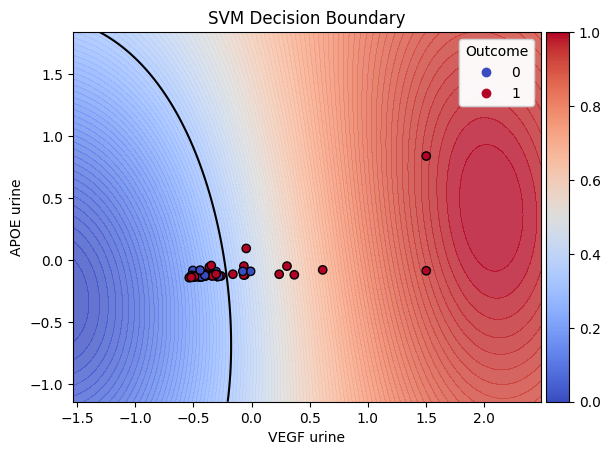

In [49]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import shutil

def plot_svm_decision_boundary(svm_model, X, y, dir, columns_indexes, feature_indices=(0, 1), resolution=0.02):
    """
    Plots the decision boundary for a trained SVM model using two selected features.
    
    :param svm_model: A trained instance of SVC.
    :param X: The full feature set that the svm_model was trained on.
    :param y: The class labels.
    :param feature_indices: A tuple containing the indices of the two features to use for the plot.
    :param resolution: The resolution of the meshgrid for plotting.
    """
    # Calculate the mean of each feature
    feature_means = X.mean(axis=0)
    
    # Create a mesh grid on the range of selected features
    x_min, x_max = X[:, feature_indices[0]].min() - 1, X[:, feature_indices[0]].max() + 1
    y_min, y_max = X[:, feature_indices[1]].min() - 1, X[:, feature_indices[1]].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Prepare the synthetic data: set the features not being varied to their mean values
    Z_data = np.full((xx.ravel().shape[0], X.shape[1]), feature_means)
    Z_data[:, feature_indices[0]] = xx.ravel()
    Z_data[:, feature_indices[1]] = yy.ravel()

    # Predict the function value for the whole grid
    Z = svm_model.decision_function(Z_data).reshape(xx.shape)

    plt.clf()
    # Plot decision boundary and margins
    im = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8, levels=np.linspace(Z.min(), Z.max(), 100))
    imc = plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['-'])

    # Plot the training points for the features being varied
    scatter = plt.scatter(X[:, feature_indices[0]], X[:, feature_indices[1]], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

    plt.title('SVM Decision Boundary')
    plt.xlabel(columns_indexes[feature_indices[0]])
    plt.ylabel(columns_indexes[feature_indices[1]])
     # Create legend
    legend_elements = scatter.legend_elements()
    legend = plt.legend(*legend_elements, title="Outcome", loc='upper right', bbox_to_anchor=(1, 1))
    plt.gca().add_artist(legend)

    # Adjust the color bar
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax.set_visible(False)
    iax = inset_axes(cax, width='100%', height='100%', loc='upper left', borderpad=0)
    plt.colorbar(cax=iax, orientation='vertical')

    # Save and show plot
    plt.savefig(f"{dir}/{feature_indices[0]} - {feature_indices[1]}.png")
    #plt.show()
    return svm_model.predict(X)

dir = './SVMPlots'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

columns_indexes = {i: c for i, c in enumerate(data.columns)}
for f1, f2 in list(itertools.combinations(np.arange(len(data.columns)-1) ,2)):
    print(f1, f2)
    plot_svm_decision_boundary(trained_models["SVM"], X_test, y_test, dir, columns_indexes, feature_indices=(f1, f2))